# Table pipeline
## TODO
    * マルチクラス対応
    * FeatureImportance 各Foldの平均にする
    * null imporatnce表示
    * Target Encording

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from matplotlib import pyplot
import seaborn as sns
import os

from sklearn import preprocessing
import matplotlib.pyplot as plt
import statistics
        
# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from optuna.integration import lightgbm_tuner
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
import gc
import json
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
import warnings

import random
from collections import Counter, defaultdict

warnings.filterwarnings('ignore')

In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [2]:
from sklearn.metrics import mean_squared_error

class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, target, categoricals=[], n_splits=5, verbose=True, random_state=42):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.random_state = random_state
        self.target = target
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params()
        self.y_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        # ↓StratifiedGroupKfold用
        #return stratified_group_k_fold(self.train_df, self.train_df['target'], self.train_df['session_id'].drop_duplicates(), self.n_splits, seed=self.random_state)
        
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
    
    def calc_score(self, true, pred):
        raise NotImplementedError
        
    def fit(self):
        oof_pred = np.zeros((len(self.train_df), ))
        y_pred = np.zeros((len(self.test_df), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val, y_accuracy_group = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            #print('Partial QWK score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_accuracy_group, oof_pred[val_idx])[1]))
            print('Partial score of fold {} is: {}'.format(fold, self.calc_score(y_val, oof_pred[val_idx])))
        self.oof_pred = oof_pred
        self.model = model
        #_, loss_score, _ = eval_qwk_lgb_regr(self.train_df['accuracy_group'], oof_pred)
        loss_score = self.calc_score(self.train_df[self.target], oof_pred)
        if self.verbose:
            #print('Our oof QWK is: ', loss_score)
            print('Our oof is: ', loss_score)
        return y_pred, loss_score, model

In [3]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100
                    }
        return params
    
    def calc_score(self, true, pred):
        return np.sqrt(mean_squared_error(true, pred))
    
    def show_importance(self, figsize=(20, 20)):
        feature_imp = pd.DataFrame(
            [self.model.feature_importance(), self.features]).T
        feature_imp.columns=["value", "feature"]

        plt.figure(figsize=figsize)
        sns.barplot(
            x="value",
            y="feature",
            data=feature_imp.sort_values(by="value", ascending=False).head(80))
        plt.title("LGBM Features")
        plt.tight_layout()
        plt.show()
        
    def get_importance(self):
        return pd.DataFrame([self.model.feature_importance(), self.features]).T

In [4]:
class Lgb_Model_Classifier(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    #'metric': 'auc',
                    'metric': 'binary_logloss',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100
                    }
        return params
    
    def calc_score(self, true, pred):
        return roc_auc_score(true, pred)
    
    def show_importance(self, figsize=(20, 20)):
        feature_imp = pd.DataFrame(
            [self.model.feature_importance(), self.features]).T
        feature_imp.columns=["value", "feature"]

        plt.figure(figsize=figsize)
        sns.barplot(
            x="value",
            y="feature",
            data=feature_imp.sort_values(by="value", ascending=False).head(80))
        plt.title("LGBM Features")
        plt.tight_layout()
        plt.show()
        
    def get_importance(self):
        return pd.DataFrame([self.model.feature_importance(), self.features]).T

In [5]:
train_file_name= './titanic_train.csv'
test_file_name= './titanic_test.csv'

In [6]:
#CSV読み込み
df_train = pd.read_csv(train_file_name)
df_test = pd.read_csv(test_file_name)

display(df_train.head(5))
display(df_test.head(5))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Age            float64
Cabin           object
Embarked        object
Fare           float64
Name            object
Parch            int64
PassengerId      int64
Pclass           int64
Sex             object
SibSp            int64
Survived       float64
Ticket          object
dtype: object

'train shape is :(891, 12)'

'test shape is :(418, 11)'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000161F4709F28>]],
      dtype=object)

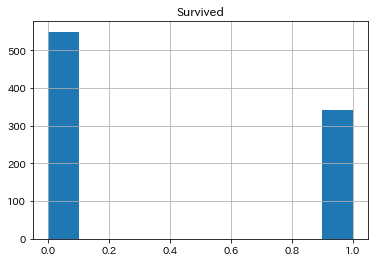

In [7]:
target='Survived'

#EDA
display(df_train.describe())
display(df_train.append(df_test).dtypes)

display('train shape is :{}'.format(df_train.shape))
display('test shape is :{}'.format(df_test.shape))

df_train[[target]].hist()

In [8]:
# カテゴリカル変数
numerics = ['Age', 'Fare']
categoricals = ['Pclass', 'Name', 'Sex', 'SibSp', 'Ticket', 'Cabin', 'Embarked']

#欠損値補完
for column in numerics:
    df_train[column] = df_train[column].fillna(df_train.append(df_test)[column].median()).replace(np.inf, 999)
    df_test[column] = df_test[column].fillna(df_train.append(df_test)[column].median()).replace(np.inf, 999)

for column in categoricals:
    df_train[column] = df_train[column].fillna(df_train.append(df_test)[column].mode().iloc[0])
    df_test[column] = df_test[column].fillna(df_train.append(df_test)[column].mode().iloc[0])

#ダミー変数ラベルエンコーディング
for column in categoricals:
    le = preprocessing.LabelEncoder()
    le.fit(df_train.append(df_test)[column])
    df_train[column] = le.transform(df_train[column])
    df_test[column] = le.transform(df_test[column])

In [313]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,2,155,1,22.0,1,0,720,7.2500,80,2
1,2,1,0,286,0,38.0,1,0,816,71.2833,106,0
2,3,1,2,523,0,26.0,0,0,914,7.9250,80,2
3,4,1,0,422,0,35.0,1,0,65,53.1000,70,2
4,5,0,2,22,1,35.0,0,0,649,8.0500,80,2


In [314]:
features = ['Pclass', 'Name', 'Sex', 'SibSp', 'Ticket', 'Cabin', 'Embarked', 'Age', 'Fare']

## HPO
lightgbm_tuner

In [315]:
lgb_model = Lgb_Model_Classifier(df_train, df_test, features, target, categoricals=categoricals)

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.476624	valid_1's binary_logloss: 0.464668
[200]	training's binary_logloss: 0.418229	valid_1's binary_logloss: 0.412553
[300]	training's binary_logloss: 0.387387	valid_1's binary_logloss: 0.397208
[400]	training's binary_logloss: 0.363722	valid_1's binary_logloss: 0.391511
[500]	training's binary_logloss: 0.344661	valid_1's binary_logloss: 0.387938
[600]	training's binary_logloss: 0.329636	valid_1's binary_logloss: 0.388426
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.337354	valid_1's binary_logloss: 0.387536
Partial score of fold 0 is: 0.8879446640316205
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.457985	valid_1's binary_logloss: 0.51913
[200]	training's binary_logloss: 0.395176	valid_1's binary_logloss: 0.495314
[300]	training's binary_logloss: 0.365352	valid_1's binary_logloss: 0.493166
Early stopping, best iter

,0,1
8,1568,Fare
7,1280,Age
0,482,Pclass
6,348,Embarked
2,344,Sex
5,71,Cabin
3,5,SibSp
1,0,Name
4,0,Ticket


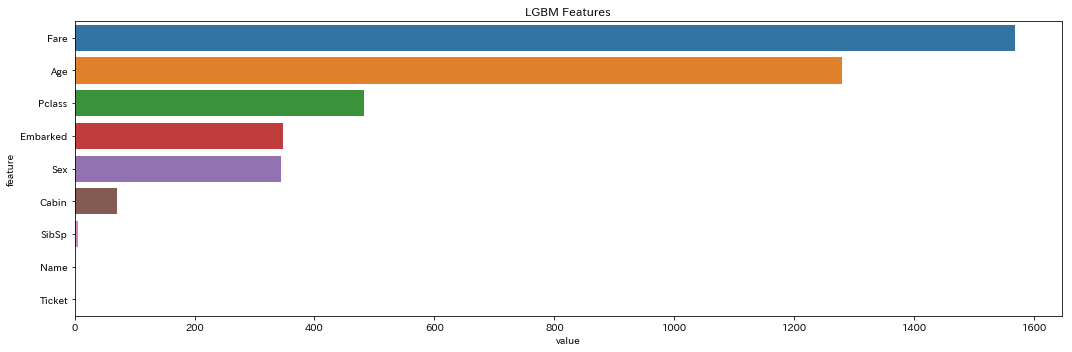

In [321]:
display(lgb_model.get_importance().sort_values(0, ascending=False))
lgb_model.show_importance(figsize=(15,5))

In [322]:
df_test[target + '_pred'] = lgb_model.y_pred
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_pred
0,892,2,638,1,34.5,0,0,376,7.8292,80,1,0.108371
1,893,2,1266,0,47.0,1,0,582,7.0000,80,2,0.326269
2,894,1,837,1,62.0,0,0,184,9.6875,80,1,0.100941
3,895,2,1278,1,27.0,0,0,366,8.6625,80,2,0.153218
4,896,2,543,0,22.0,1,1,338,12.2875,80,2,0.354298


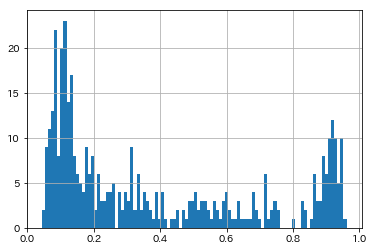

In [324]:
df_test[target + '_pred'].hist(bins=100)